# Анализ успеваемости студентов МГТУ им. Н. Э. Баумана

![](https://fotograf-nedvizhimosti.ru/wp-content/uploads/mgtu.jpg)

## Описание

Задачей проекта является предсказание факта отчисления или окончания для студента МГТУ им. Н. Э. Баумана. Набор данных представляет собой несколько датасетов для каждого факультета с оценками по всем предметам, которые студент сдавал в течение конкретной сессии. 

Предсказательная модель позволит обучающемуся узнать наиболее вероятный исход, связанный с будущим статусом обучения в данном высшем учебном заведении. В случае неутешительного прогноза студент получит сигнал о необходимости увеличить прикладываемые усилия.

In [1]:
import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, f1_score, plot_confusion_matrix, \
     plot_roc_curve, plot_precision_recall_curve, classification_report, precision_score, recall_score
from eli5.sklearn import PermutationImportance
import eli5
from tqdm import tqdm

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

from Group import *
from Student import *

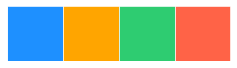

In [4]:
colors = ["dodgerblue", "orange", "#2ecc71", "tomato"]
sns.palplot(sns.color_palette(colors))

## Загрузка данных

Датасеты содержат информацию об оценках студентов следующих факультетов:

- Машиностроительные технологии (МТ)
- Информатика и системы управления (ИУ)
- Специальное машиностроение (СМ)
- Энергомашиностроение (Э)
- Инженерный бизнес и менеджмент (ИБМ)
- Радиоэлектроника и лазерная техника (РЛ)
- Робототехника и комплексная автоматизация (РК)
- Фундаментальные науки (ФН)
- Ракетно-космическая техника (РКТ)

Ниже приведены данные по факультету МТ.

In [4]:
fac_datasets = ['МТ', 'ИУ', 'СМ', 'Э', 'ИБМ', 'РЛ', 'РК', 'ФН', 'РКТ']
dataset = fac_datasets[7]
dataset_directory = '/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/data new merge without last sessions/'
dataset_path = f'{dataset_directory}{dataset}.txt'
df_faculty = pd.read_csv(dataset_path, low_memory=False).iloc[:,1:]

In [4]:
df_faculty.head()

,#Группы,#Сессии,ФИО,Номер зачетки,Курсовой проект - Многомерный статистический анализ,Атомарные функции и вейвлеты в физических приложениях (Спецкурс),Военная подготовка,Методы выборочного обследования,Основы предпринимательства,Дополнительные главы теории случайных процессов,...,Методология и педагогика в обучении физике,Курсовая работа - Стохастические системы в физики и техники,Дисциплина по выбору 1,Физика металлов и полупроводников,Полимерные наноматериалы,Нанобиотехнологии,Химические технологии производства наноматериалов,Элементы и устройства вычислительной техники и систем управления,3D моделирование и прототипирование,Проектирование элементной базы наносистем
0,ФН1-101,11,Андрейцева Кристина Сергеевна,06Ф068,5.0,True,NaN,True,True,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ФН1-101,11,Ахметшина Диляра Тимуровна,06Ф003,4.0,True,NaN,True,True,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ФН1-101,11,Багатурия Шалва Зурабович,06Ф004,5.0,True,True,True,True,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ФН1-101,11,Глотова Анна Владимировна,06Ф060,3.0,True,NaN,True,True,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ФН1-101,11,Дедиков Игорь Игоревич,06Ф007,5.0,True,True,True,True,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_faculty.shape

(14703, 495)

In [6]:
#Функция позволяет узнать диапазон представленных сессий, увидеть отсутствующие сессии

def get_session_numbers():
    global latest_session
    latest_session = df_faculty['#Сессии'].sort_values().values[-1]
    global earliest_session
    earliest_session = df_faculty['#Сессии'].sort_values().values[0]
    sessions = df_faculty['#Сессии'].unique().tolist()
    missing_sessins = [x for x in range(earliest_session, latest_session+1) if x not in sessions]

    print('В таблице представлен диапазон сессий с', earliest_session, 'по', latest_session)
    print('Отсутствуют данные по следующим сессиям: ', end ='')
    print(*missing_sessins, sep=', ')

In [7]:
get_session_numbers()

В таблице представлен диапазон сессий с 4 по 33
Отсутствуют данные по следующим сессиям: 32


Сессия №4 соответствует зимней сессии 2007 года, сессия №33 - летней сессии 2022 года.

## Обработка и очистка данных

### Замена значений

Проверим, какие уникальные значения содержат поля с оценками.

In [9]:
df_only_marks = df_faculty.iloc[:, 4:]
unique_values = pd.unique(df_only_marks.values.ravel('K')).tolist()

print(unique_values)

[5.0, 4.0, 3.0, nan, True, False, 'True', '\xa0\xa0\xa0\xa0', '5.0', '4.0', '3.0', 'False', 'Д', '0.0', '1.0', 'Напр']


Обозначения в системе записей оценок в деканате:
- 'True' - зачёт
- 'False' - незачёт или 2 за экзамен
- 'Д' - недопуск
- 'П' - перенос (например из-за болезни)
- 'Напр' - выдано направление на сдачу
- '\xa0\xa0\xa0\xa0' - незаполненное (пустое) поле в электронном университете

Поменяем оценки, у которых тип 'string' на 'float'. Также преобразуем булевы значения в тип 'string'.

In [5]:
def replace_marks():
    global df_faculty
    df_faculty.replace({3: 3.0, '3': 3.0, '3.0': 3.0,
                        4: 4.0, '4': 4.0, '4.0': 4.0,
                        5: 5.0, '5': 5.0, '5.0': 5.0,
                        1: 'True', 1.0: 'True', '1': 'True', '1.0': 'True',
                        0: 'False', 0.0: 'False', '0': 'False', '0.0': 'False',
                        True: 'True', False: 'False'}, inplace=True)

In [15]:
replace_marks()

В МГТУ им. Н. Э. Баумана отчисляют, если у студента период наличия задолженности превышает один год. Можно утверждать, что если такие оценки как 'недопуск', 'перенос' и незаполненные поля не заменили в течение года в деканате на положительные, то они равносильны несдаче дисциплины. Следовательно, данные оценки можно заменить на 'False'. Проверим предположение графически, сравнив количество должников до замены и после.

In [16]:
ses_debts_bef = pd.DataFrame(df_faculty[(df_faculty == 'False').any(axis=1)].groupby(['#Сессии']).size())

df_faculty.replace({'П': 'False', 'Д': 'False', 'Напр': 'False', '\xa0\xa0\xa0\xa0': 'False'}, inplace=True)

ses_debts_aft = pd.DataFrame(df_faculty[(df_faculty == 'False').any(axis=1)].groupby(['#Сессии']).size())

df_debt_ses = ses_debts_bef.merge(ses_debts_aft, how='outer', on='#Сессии'). \
                              rename(columns={'0_x': 'Количество задолженностей до замены', \
                                              '0_y': 'Количество задолженностей после замены'}). \
                              fillna(0)

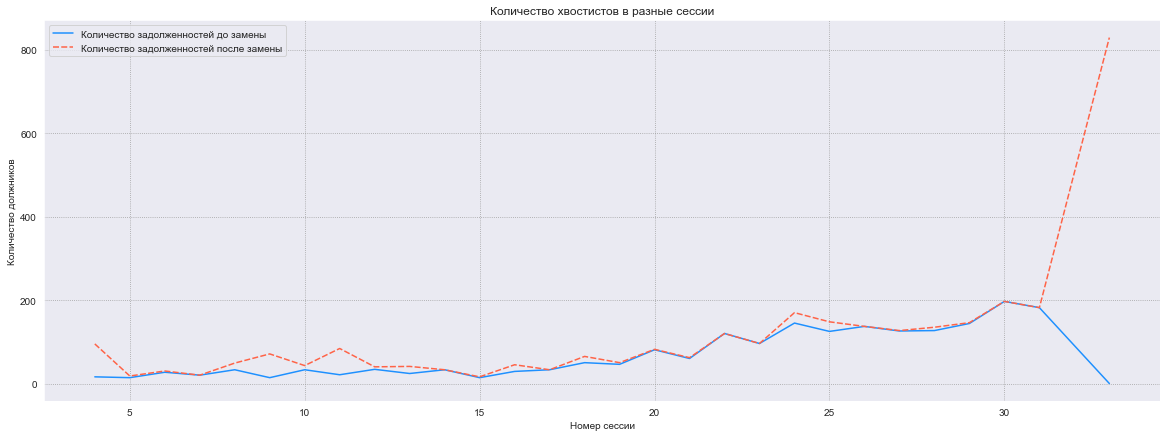

In [25]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(20,7))
sns.lineplot(data=df_debt_ses, palette = [colors[0],colors[3]])
plt.title('Количество хвостистов в разные сессии')
plt.xlabel("Номер сессии")
plt.ylabel("Количество должников")

plt.show()

На графиках выше можем убедиться, что до 31 сессии включительно деканат большую часть неопределённых оценок заменил на неудовлетворительные. С введением электронного университета в 4 сессии (2007 год) деканат не всегда контролировал статус оценок обучающихся, однако со временем всё более тщательно подходил к данному вопросу. Начиная с 31 сессии студенты находятся в процессе сдачи задолженностей, именно поэтому графики с 31 сессии (2021) года расходятся.

После замены всех значений в полях таблицы сохранились только отражающие успеваемость оценки студентов и пропущенные значения. Последние остаются в виду формы датасетов, содержащих все предметы факультета.

In [12]:
df_only_marks = df_faculty.iloc[:, 4:]
unique_values = pd.unique(df_only_marks.values.ravel('K')).tolist()

print(unique_values)

[5.0, 4.0, 3.0, 'False', nan, 'True']


### Удаление записей

Построим графиики распределения периодов обучения студентов (как успешных, так и отчисленных) с целью выявления выбросов.

In [34]:
#Функция строит графики распределения периодов обучения 

def get_compare_distributions():

    group = df_faculty.groupby(['Номер зачетки','ФИО'])
    student = list(group.groups)
    study_periods_unique = [Student(group.get_group(i)).study_period for i in student]
    good_study_periods_unique = [Student(group.get_group(i)). \
                                 study_period for i in student if not Student(group.get_group(i)).is_dropout]
    
    def get_graphs(data, i, palette_color):
        
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.distplot(pd.Series(data), bins=len(set(data)), color=colors[palette_color])
        title = ['всех', 'успешных']
        plt.title(f'Распределение периода обучения {title[i]} студентов',fontsize=15)
        plt.xlabel('Количество оконченных семестров'); plt.ylabel('Кол-во (частота)')

        plt.subplot(122)
        sns.boxplot(pd.Series(data), color=colors[palette_color])
        plt.title(f'Распределение периода обучения {title[i]} студентов',fontsize=15)
        plt.xlabel('Количество оконченных семестров'); 

    get_graphs(study_periods_unique, 0, 0)
    get_graphs(good_study_periods_unique, 1, 3)
    
    plt.show()

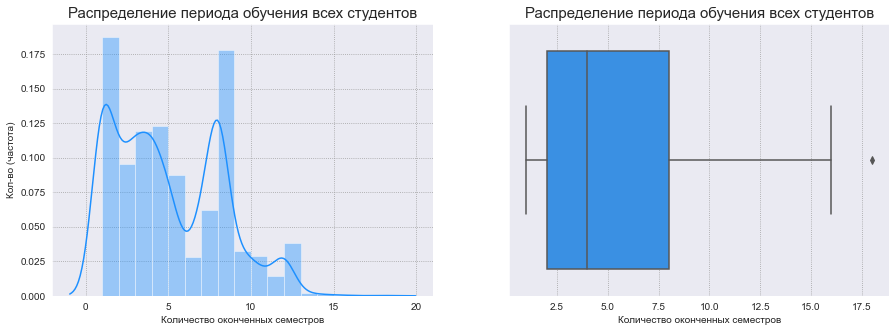

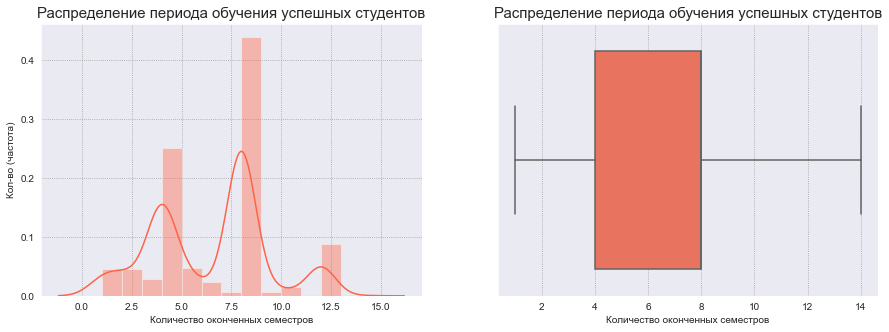

In [35]:
get_compare_distributions()

Данные графики показывают, что большое количество студентов отчисляют на первом курсе. Ниже приведены основные возможные причины данного явления:
- Студенты-первокурсники продолжают учиться точно также, как и в школе, думая, что образовательный процесс устроен так же;
- Нерегулярное посещение занятий, влекущее за собой отработки и предоставление официальных документов;
- Несерьезное отношение к первой сессии, переоценивание своих возможностей;
- Низкий уровень мотивации, чтобы продолжать учиться;
- Совмещение учебы и работы с самого первого курса;
- Неправильная расстановка приоритетов.

Для разных ступеней обучения будем считать выбросами следующие периоды обучения:
- Если бакалавр учится меньше 7 семестров и дольше 8 семестров;
- Если магистр учится меньше 3 семестров и дольше 4 семестров;
- Если аспирант учится меньше 7 семестров и дольше 8 семестров;
- Если специалист учится меньше 11 семестров и дольше 12 семестров.

Удалим записи студентов с такой длительностью обучения.

In [36]:
def create_columns():
    global df_faculty
    groups = df_faculty.groupby(['ФИО', 'Номер зачетки'])
    students = list(groups.groups)
    student = {i : Student(groups.get_group(tuple(df_faculty.iloc[:,2:4].iloc[i]))) for i in range(len(df_faculty))}
    df_faculty['Студент'] = pd.Series(student)
    study_periods = [df_faculty['Студент'][i].study_period for i in range(len(df_faculty))]
    
    grades = [df_faculty['Студент'][i].grade for i in range(len(df_faculty))]
    is_dropout = [df_faculty['Студент'][i].is_dropout for i in range(len(df_faculty))]
    expelled_immediately = [df_faculty['Студент'][i].expelled_immediately for i in range(len(df_faculty))]
    enr_year = [df_faculty['Студент'][i].enr_year for i in range(len(df_faculty))]
    last_session = [df_faculty['Студент'][i].last_session for i in range(len(df_faculty))]

    df_faculty['Период_обучения'] = pd.Series(study_periods)
    df_faculty['Ступень_образования'] = pd.Series(grades)
    df_faculty['Отчислен'] = pd.Series(is_dropout)
    df_faculty['Отчислен_сразу'] = pd.Series(expelled_immediately)
    df_faculty['Год_поступления'] = pd.Series(enr_year)
    df_faculty['Последняя_сессия'] = pd.Series(last_session)

In [37]:
create_columns()

In [38]:
df_faculty = df_faculty.query("((Ступень_образования=='Б' & 7 <= Период_обучения <= 8) | \
                                (Ступень_образования=='М' & 3 <= Период_обучения <= 4) | \
                                (Ступень_образования=='А' & 7 <= Период_обучения <= 8) | \
                                (Ступень_образования=='Специалист' & 11 <= Период_обучения <= 12)) | \
                                (Отчислен==True)")

Произведём удаление записей тех студентов, у которых присутствует хотя бы одна неудовлетворительная оценка в первом семестре обучения, поскольку предсказать дальнейшее отчисление или успешное завершение обучения уже не получится.

In [39]:
df_faculty = df_faculty.query("Отчислен_сразу==False")

Наконец, удалим записи тех студентов, периоды обучения которых не полностью зафиксированы в электронном университете. С одной стороны такая ситуация связана с тем, что ведение электронного учёта появилось только в 2007 году, с другой - с тем, что некоторые студенты всё ещё продолжают обучениие.

In [40]:
df_faculty = df_faculty.query("(Год_поступления >= 2007) & (Последняя_сессия <= 29)")

In [41]:
df_faculty = df_faculty.iloc[:,:-7]
df_faculty.reset_index(inplace=True, drop=True)

Построим снова графики распределения обучения студентов.

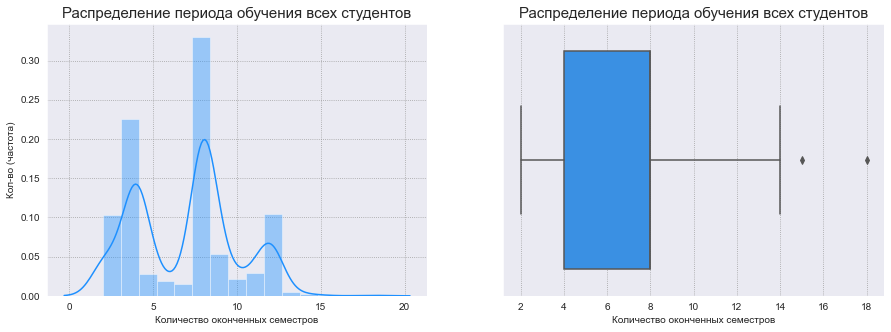

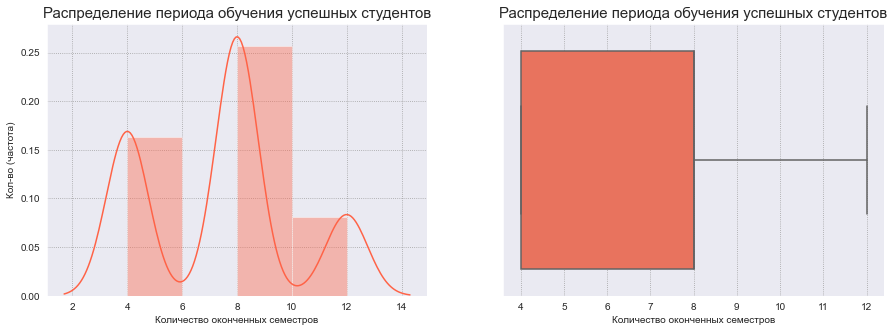

In [42]:
get_compare_distributions()

На графиках можем наблюдать локальные максимумы в точках, соответствующих периодам в 4 семестра (период обучения в магистратуре), 7-8 семестров (период обучения в бакалавриате), а также 12 семестров (период обучения на специалитете). Остальные периоды обучения присутствуют на графиках обучения успешных студентов из-за возможного перевода студентов в другие ВУЗы или на другие специальности.

In [22]:
get_session_numbers()

В таблице представлен диапазон сессий с 4 по 29
Отсутствуют данные по следующим сессиям: 


In [23]:
#Сохраняем очищенные данные

clean_directory = '/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/clean data/'
clean_path = f'{clean_directory}{dataset}_clean.txt'
df_faculty.to_csv(clean_path)

## Конструирование признаков

### Таблица для разведочного анализа

Добавим следующие признаки в данные студентов:
- информация о факультете;
- средний балл до семестра, который не закрыт (если такой имеется);
- период обучения, не включающий долги студента (если есть);
- пол

In [5]:
def create_fac_df():
    global fac_df
    fac_df = {}
    dataset_directory = '/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/clean data/'
    global df_faculty
    for i in tqdm(fac_datasets):
        dataset = i
        dataset_path = f'{dataset_directory}{dataset}_clean.txt'
        df_faculty = pd.read_csv(dataset_path, low_memory=False).iloc[:,1:]
        replace_marks()
        fac_df[i] = df_faculty.to_dict()

In [ ]:
create_fac_df()

In [5]:
def create_eda_fac_df():
    global df_faculty
    groups = df_faculty.groupby(['ФИО', 'Номер зачетки'])
    students = list(groups.groups)
    student = {i : Student(groups.get_group(tuple(df_faculty.iloc[:,2:4].iloc[i]))) for i in range(len(df_faculty))}
    df_faculty.insert(df_faculty.shape[1]-4, 'Студент', pd.Series(student))
    
    mean_mark = [df_faculty['Студент'][i].mean_mark for i in range(len(df_faculty))]
    faculty = [df_faculty['Студент'][i].faculty for i in range(len(df_faculty))]
    good_study_period = [df_faculty['Студент'][i].good_study_period for i in range(len(df_faculty))]
    grades = [df_faculty['Студент'][i].grade for i in range(len(df_faculty))]
    is_dropout = [df_faculty['Студент'][i].is_dropout for i in range(len(df_faculty))]
    enr_year = [df_faculty['Студент'][i].enr_year for i in range(len(df_faculty))]
    
    df_faculty['Средняя оценка'] = pd.Series(mean_mark)
    df_faculty['Факультет'] = pd.Series(faculty)
    df_faculty['Законченных семестров'] = pd.Series(good_study_period)
    df_faculty['Ступень_образования'] = pd.Series(grades)
    df_faculty['Отчислен'] = pd.Series(is_dropout)
    df_faculty['Год_поступления'] = pd.Series(enr_year)
    
    df_faculty = df_faculty.rename(columns={'ФИО': 'Имя'})
    df_faculty['Имя'] = df_faculty['Имя'].map(lambda name: re.split(r"\s", name)[1])
    
    df_name_gender = pd.read_csv('/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/russian_names.csv', sep=';'). \
                        iloc[:,1:].rename(columns={'Sex': 'Пол', 'Name': 'Имя'})
    df_faculty = df_faculty.merge(df_name_gender, how='inner', on='Имя').iloc[:,:-3]
    df_faculty = df_faculty.drop(df_faculty.iloc[:, 4:-8], axis=1).iloc[:, 2:].drop_duplicates()
    

In [6]:
for i in tqdm(fac_datasets):
    df_faculty = pd.DataFrame(fac_df[i])
    create_eda_fac_df()
    fac_df[i] = df_faculty.to_dict()

100%|████████████████████████████████████████████| 9/9 [36:26<00:00, 243.00s/it]


In [20]:
def concat_eda_df():
    global eda_df
    eda_df = pd.DataFrame()
    eda_df = eda_df.append(pd.DataFrame(fac_df[fac_datasets[-1]]))
    for i in range(len(fac_datasets)-1):
        eda_df = pd.concat([eda_df, pd.DataFrame(fac_df[fac_datasets[i]])])
    eda_df = eda_df.drop(columns=['Имя', 'Номер зачетки'])

In [24]:
concat_eda_df()
eda_df.to_csv('/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/eda.txt')

### Таблица для моделирования

Датасет для моделирования содержит следующие признаки:
- информация о факультете;
- средний балл в текущем семестре;
- средний балл в первом семестре;
- средний балл за время обучения на текущиий момент;
- разные периоды обучения, не включающие долги студента (если есть);
- ступень образования;
- пол;
- учебный статус студента в грядущем семестре (целевая переменная)

In [6]:
create_fac_df()

100%|█████████████████████████████████████████████| 9/9 [02:44<00:00, 18.24s/it]


In [7]:
def create_mod_fac_df():
    global df_faculty
    groups = df_faculty.groupby(['ФИО', 'Номер зачетки'])
    students = list(groups.groups)
    student = {i : Student(groups.get_group(tuple(df_faculty.iloc[:,2:4].iloc[i]))) for i in range(len(df_faculty))}
    student_ind = {i : Student(df_faculty[df_faculty.index==i]) for i in range(len(df_faculty))}
    student_yet = {i : Student(groups.get_group(tuple(df_faculty.iloc[:,2:4].iloc[i])).sort_values(by='#Сессии'). \
                   loc[groups.get_group(tuple(df_faculty.iloc[:,2:4].iloc[i])).sort_values(by='#Сессии')['#Сессии'] \
                   <= student_ind[i].first_session]) for i in range(len(df_faculty))}
    student_first = {i : Student(groups.get_group(tuple(df_faculty.iloc[:,2:4].iloc[i])).sort_values(by='#Сессии').head(1)) \
                     for i in range(len(df_faculty))}
    
    mean_mark_now = [student_ind[i].mean_mark for i in range(len(df_faculty))]
    mean_mark_yet = [student_yet[i].mean_mark if student_yet[i].is_dropout == False else None \
                 for i in range(len(df_faculty))]
    mean_mark_first = [student_first[i].mean_mark for i in range(len(df_faculty))]
    faculty = [student[i].faculty for i in range(len(df_faculty))]
    study_period_yet = [student_yet[i].study_period if mean_mark_yet[i] != None else None \
                    for i in range(len(df_faculty))]
    grades = [student[i].grade for i in range(len(df_faculty))]
    is_dropout_yet = [student_yet[i].is_dropout for i in range(len(df_faculty))]
    
    df_faculty = df_faculty.drop(df_faculty.iloc[:, 4:], axis=1)
    
    df_faculty['mean_mark_now'] = pd.Series(mean_mark_now)
    df_faculty['mean_mark_yet'] = pd.Series(mean_mark_yet)
    df_faculty['mean_mark_first'] = pd.Series(mean_mark_first)
    df_faculty['faculty'] = pd.Series(faculty)
    df_faculty['study_period_yet'] = pd.Series(study_period_yet)
    df_faculty['grades'] = pd.Series(grades)
    df_faculty['is_dropout_yet'] = pd.Series(is_dropout_yet)
    
    df_faculty = df_faculty.rename(columns={'ФИО': 'name'})
    df_faculty['name'] = df_faculty['name'].map(lambda name: re.split(r"\s", name)[1])
    
    df_name_gender = pd.read_csv('/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/russian_names.csv', sep=';'). \
                        iloc[:,1:].rename(columns={'Sex': 'sex', 'Name': 'name'})
    df_faculty = df_faculty.merge(df_name_gender, how='inner', on='name').iloc[:,:-3]

In [8]:
def shift_mod_fac_df():
    global df_faculty
    groups = df_faculty.groupby(['name', 'Номер зачетки'])
    students = list(groups.groups)
    mod_fac_df = groups.get_group(students[-1]).reset_index(drop=True)
    mod_fac_df['is_dropout_yet'] = mod_fac_df['is_dropout_yet'].shift(periods=-1, fill_value=False)

    if len(mod_fac_df[(mod_fac_df != False).all(axis=1)]) > 0:
        mod_fac_df = mod_fac_df.head(mod_fac_df.query('is_dropout_yet==True').index[0] + 1)

    for i in range(len(students)-1):
        mod_fac_df_i = groups.get_group(students[i]).reset_index(drop=True)
        mod_fac_df_i['is_dropout_yet'] = mod_fac_df_i['is_dropout_yet'].shift(periods=-1, fill_value=False)

        if len(mod_fac_df_i[(mod_fac_df_i != False).all(axis=1)]) > 0:
            mod_fac_df_i = mod_fac_df_i.head(mod_fac_df_i.query('is_dropout_yet==True').index[0] + 1)

        mod_fac_df = pd.concat([mod_fac_df, mod_fac_df_i])

    df_faculty = mod_fac_df.rename(columns={'is_dropout_yet': 'will_dropout'}).\
                            iloc[:,4:].dropna(). \
                            reset_index(drop=True)

In [9]:
for i in tqdm(fac_datasets):
    df_faculty = pd.DataFrame(fac_df[i])
    create_mod_fac_df()
    shift_mod_fac_df()
    fac_df[i] = df_faculty.to_dict()

100%|████████████████████████████████████████████| 9/9 [55:34<00:00, 370.50s/it]


In [10]:
def concat_mod_df():
    global mod_df
    mod_df = pd.DataFrame()
    mod_df = mod_df.append(pd.DataFrame(fac_df[fac_datasets[-1]]))
    for i in range(len(fac_datasets)-1):
        mod_df = pd.concat([mod_df, pd.DataFrame(fac_df[fac_datasets[i]])])

In [11]:
concat_mod_df()
mod_df.to_csv('/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/mod.txt')

## Разведочный анализ данных

### Загрузка датасетов для анализа

**Гипотезы:**

1. Чем выше средний балл студента, тем меньше вероятность отчисления.
2. Сложнее всего учиться на факультете фундаментальных наук, на инженерных факультетах учиться проще.
3. Специалистов отчисляют чаще, так как требуется закончить больше семестров для получения диплома.
4. В МГТУ им. Н. Э. Баумана половая принадлежность студента не влияет на успех в обучении.
5. Самым важным критерием вероятности отчисления человека является период его обучения.

In [2]:
eda_df = pd.read_csv('/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/eda.txt').iloc[:,1:]
mod_df = pd.read_csv('/Users/tihonstrelcov/Downloads/Projects/bmstuDataAnalysis/bmstuDataAnalysis/mod.txt').iloc[:,1:]

In [7]:
eda_df

,Средняя оценка,Факультет,Законченных семестров,Ступень_образования,Отчислен,Год_поступления,Пол
0,4.48,РКТ,10,Специалист,True,2009,Ж
1,4.30,РКТ,9,Специалист,True,2012,Ж
2,3.50,РКТ,1,Специалист,True,2011,Ж
3,3.00,РКТ,1,Специалист,True,2014,Ж
4,3.82,РКТ,10,Специалист,True,2009,М
...,...,...,...,...,...,...,...
21390,4.24,ФН,8,Б,False,2015,М
21391,3.95,ФН,8,Б,False,2016,Ж
21392,4.75,ФН,8,Б,False,2016,Ж
21393,3.69,ФН,3,Б,True,2017,М


In [15]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21395 entries, 0 to 21394
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Средняя оценка         21395 non-null  float64
 1   Факультет              21395 non-null  object 
 2   Законченных семестров  21395 non-null  int64  
 3   Ступень_образования    21395 non-null  object 
 4   Отчислен               21395 non-null  bool   
 5   Год_поступления        21395 non-null  int64  
 6   Пол                    21395 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 1023.9+ KB


In [14]:
eda_df.nunique()

Средняя оценка           195
Факультет                  9
Законченных семестров     15
Ступень_образования        4
Отчислен                   2
Год_поступления           13
Пол                        2
dtype: int64

In [49]:
eda_df.describe()

,Средняя оценка,Законченных семестров,Год_поступления
count,21395.000000,21395.000000,21395.000000
mean,4.062088,6.988315,2012.316663
std,0.575194,3.722828,3.152904
min,3.000000,1.000000,2007.000000
25%,3.600000,4.000000,2010.000000
50%,4.070000,8.000000,2012.000000
75%,4.550000,11.000000,2015.000000
max,5.000000,15.000000,2019.000000


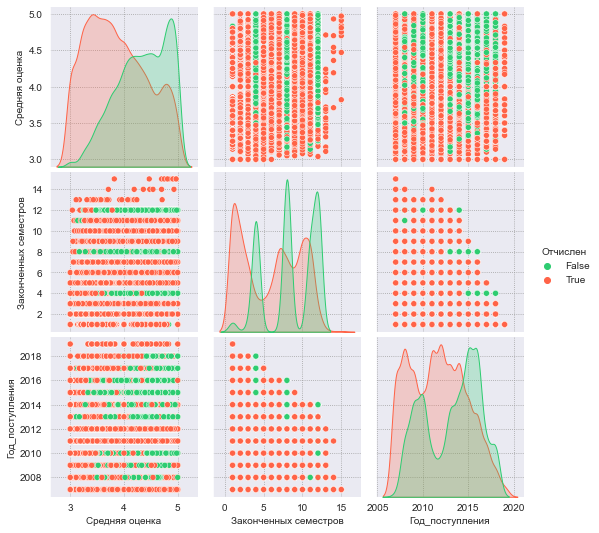

In [51]:
sns.pairplot(data=eda_df, hue='Отчислен', palette=colors[2:4])
plt.show()

In [5]:
mod_df

,mean_mark_now,mean_mark_yet,mean_mark_first,faculty,study_period_yet,grades,will_dropout,sex
0,3.00,3.00,3.00,РКТ,1.0,Специалист,True,Ж
1,3.40,3.40,3.40,РКТ,1.0,Специалист,True,М
2,4.83,4.26,4.40,РКТ,9.0,Специалист,False,М
3,4.40,4.40,4.40,РКТ,1.0,Специалист,True,М
4,3.20,3.20,3.20,РКТ,1.0,Специалист,False,М
...,...,...,...,...,...,...,...,...
98306,4.50,4.50,4.50,ФН,1.0,М,False,М
98307,4.33,4.40,4.50,ФН,2.0,М,False,М
98308,4.80,4.60,4.50,ФН,3.0,М,False,М
98309,4.00,4.46,4.50,ФН,4.0,М,False,М


In [8]:
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98311 entries, 0 to 98310
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_mark_now     98311 non-null  float64
 1   mean_mark_yet     98311 non-null  float64
 2   mean_mark_first   98311 non-null  float64
 3   faculty           98311 non-null  object 
 4   study_period_yet  98311 non-null  float64
 5   grades            98311 non-null  object 
 6   will_dropout      98311 non-null  bool   
 7   sex               98311 non-null  object 
dtypes: bool(1), float64(4), object(3)
memory usage: 5.3+ MB


In [9]:
mod_df.nunique()

mean_mark_now        57
mean_mark_yet       196
mean_mark_first      37
faculty               9
study_period_yet     13
grades                4
will_dropout          2
sex                   2
dtype: int64

In [10]:
mod_df.describe()

,mean_mark_now,mean_mark_yet,mean_mark_first,study_period_yet
count,98311.000000,98311.000000,98311.000000,98311.000000
mean,4.191595,4.113276,4.071296,4.623633
std,0.628411,0.556111,0.605878,3.159901
min,3.000000,3.000000,3.000000,1.000000
25%,3.670000,3.670000,3.600000,2.000000
50%,4.250000,4.130000,4.000000,4.000000
75%,4.750000,4.590000,4.600000,7.000000
max,5.000000,5.000000,5.000000,13.000000


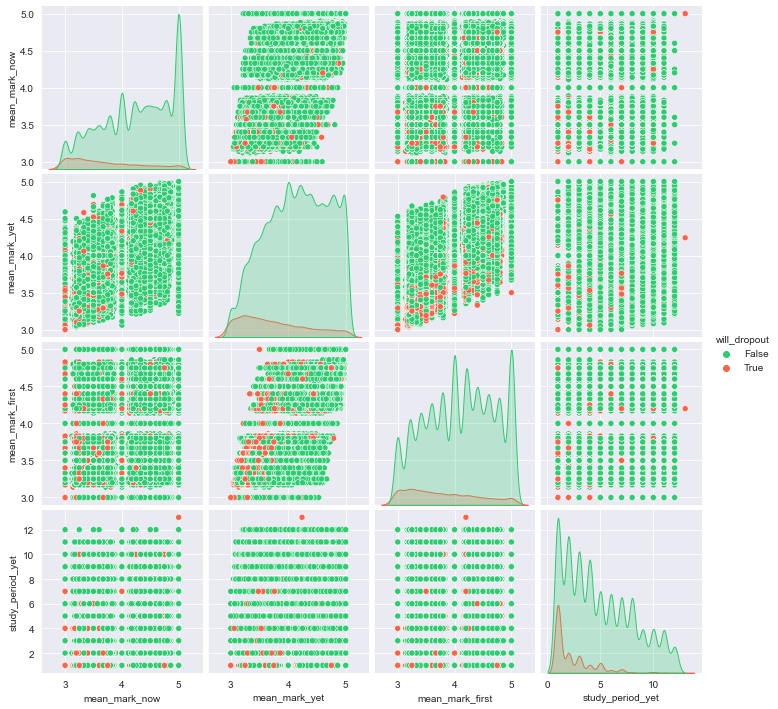

In [11]:
sns.pairplot(data=mod_df, hue='will_dropout', palette=colors[2:4])
plt.show()

**Вывод:**
- Большая часть отчисленных студентов имела скорее низкий средний балл в отличие от студентов, которые сумели дойти до конца обучения. Гипотеза подтвердилась.

### Целевая переменная

In [143]:
def compare_two(column, title, xlabel):
    norm_target = column.value_counts(normalize=True).mul(100).rename('percent').reset_index()

    plt.figure(figsize=(8, 8))
    ax = sns.barplot(x='index', y='percent', data=norm_target, palette=colors[2:4])

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=14)

    plt.title(title, fontsize=20)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Проценты, %', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

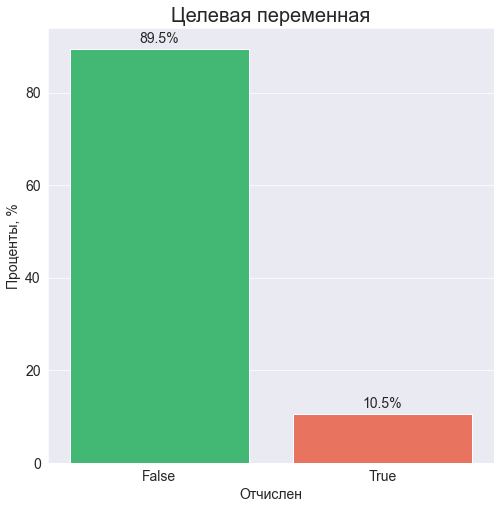

In [19]:
compare_two(mod_df.will_dropout, 'Целевая переменная', 'Отчислен')

В датесете присутствует дисбаланс классов, при обучении модели это стоит учесть.

### Статистика отчислений

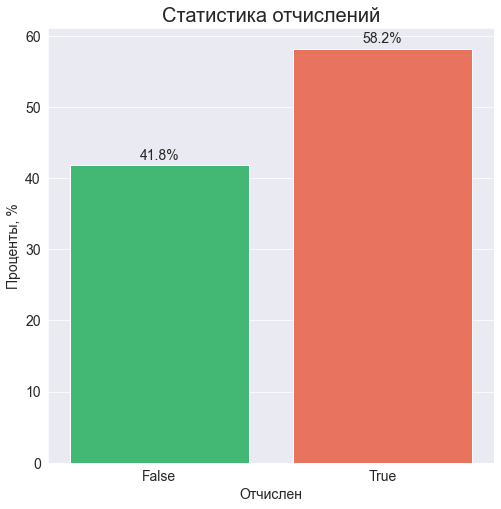

In [20]:
compare_two(eda_df['Отчислен'], 'Статистика отчислений', 'Отчислен')

In [9]:
def dist_statistics(condition, i):
    sns.displot({'Закончил': eda_df[(eda_df['Отчислен'] == False) & (condition)]['Год_поступления'], \
                 'Отчислен': eda_df[(eda_df['Отчислен'] == True) & (condition)] ['Год_поступления']}, \
                kind="kde", \
                common_norm=False, \
                palette=colors[2:4])

    plt.title(f'Статистика обучения {i}', fontsize=20)
    plt.xlabel('Год поступления', fontsize=14)
    plt.ylabel('Dentsity', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()

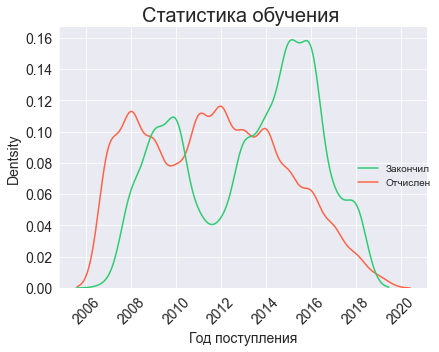

In [47]:
dist_statistics(True, '')

In [148]:
def bar_categorial(query, hue, title, palette):
    plt.figure(figsize=(18, 8))

    norm_target = query.value_counts(normalize=True).mul(100). \
                                                     rename('percent').reset_index()
    ax = sns.barplot(x=i, y="percent", hue=hue, data=norm_target, palette=palette)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=14)

    plt.title(title, fontsize=20)

    plt.xlabel(i, fontsize=14)
    plt.ylabel('Проценты, %', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14);

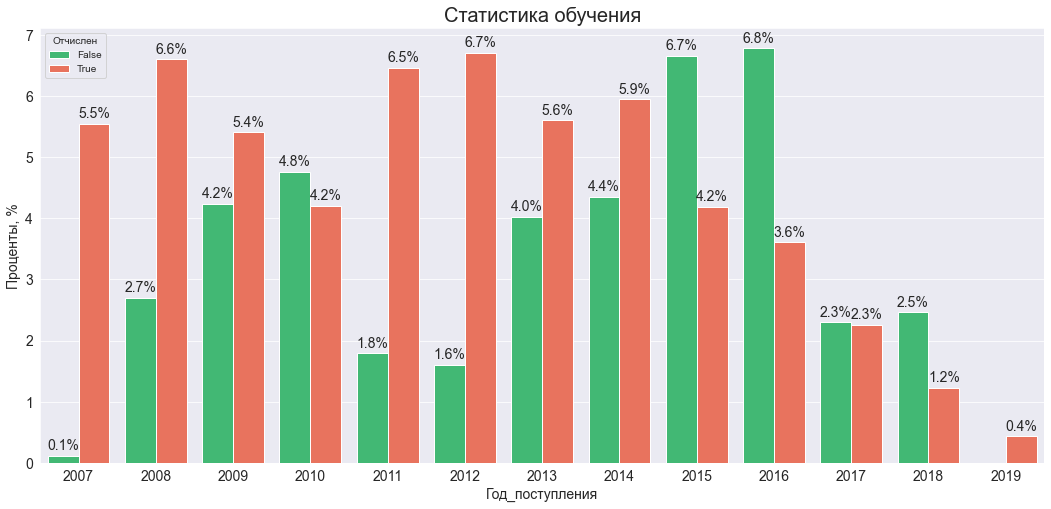

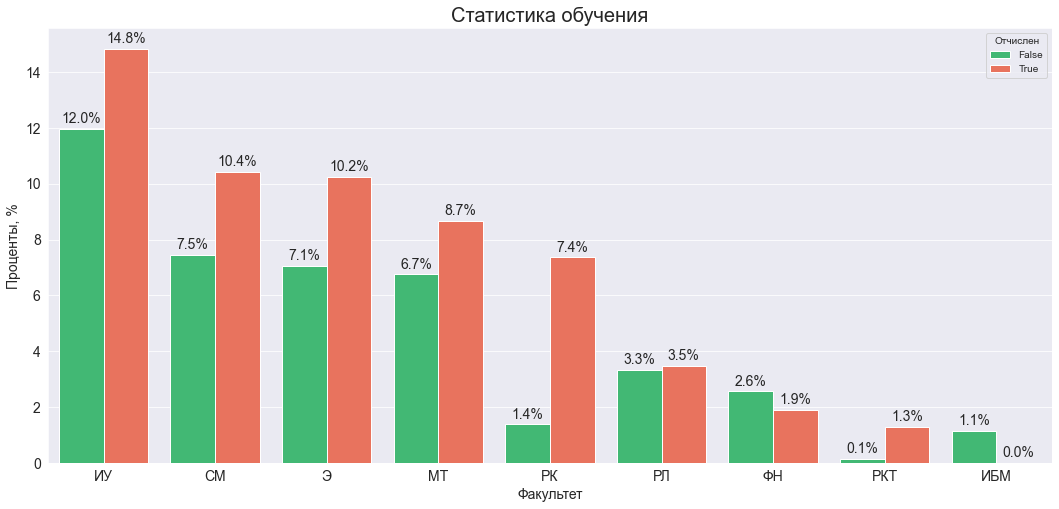

In [113]:
categorial = ['Год_поступления', 'Факультет']
for i in categorial:
    bar_categorial(eda_df[[i, 'Отчислен']], 'Отчислен', 'Статистика обучения', colors[2:4])

**Выводы:**
1. В университете студенты в среднем чаще отчисляются, чем выпускаются, однако в некоторые годы ситуация менялась на противоположную. 
2. В то время, как практически на всех факультетах отчислиться из университета более вероятно, чем его закончить (особенно на факультетах РК и РКТ), на кафедре ФН поступивший студент чаще является будущим выпускником. Предполагаемая гипотеза не подтвердилась.
3. На кафедре ИБМ практически не отчисляют. Вероятно, это связано с тем, что на данном факультете большинство студентов платят за своё обучение, и таких учащихся университету отчислить невыгодно.

### Пол

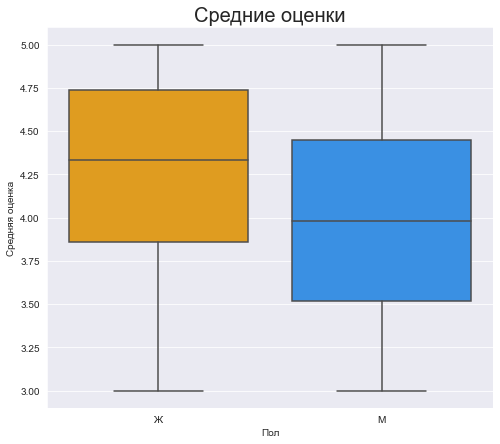

In [87]:
plt.figure(figsize=[8, 7])
sns.boxplot(x='Пол', y='Средняя оценка', data=eda_df, palette=[colors[1],colors[0]])
plt.title('Средние оценки', fontsize=20)
plt.show()

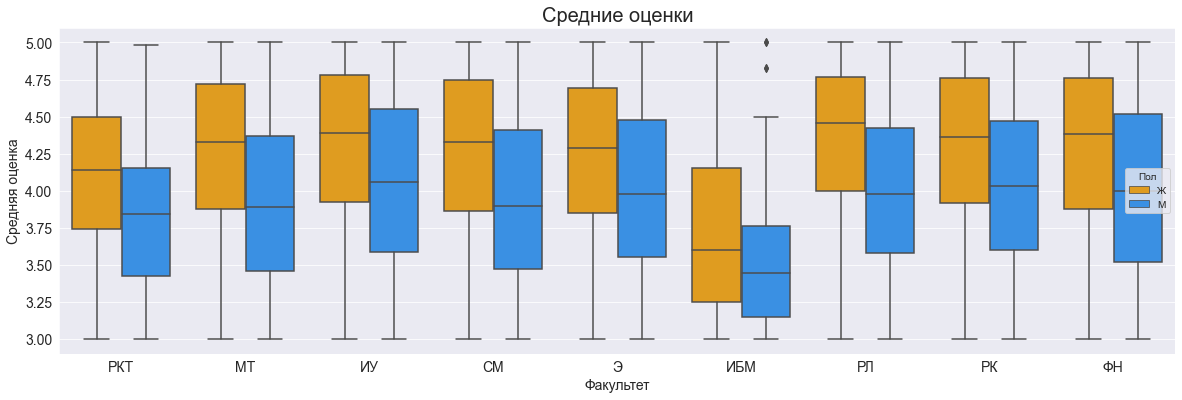

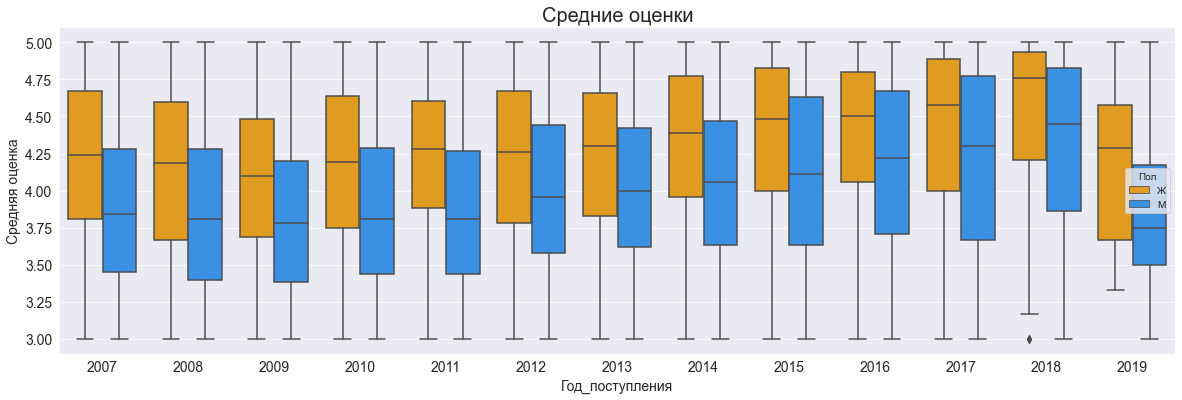

In [90]:
categorial = ['Факультет', 'Год_поступления']
 
for i in categorial:
    plt.figure(figsize=(20,6))

    sns.boxplot(x=i, y='Средняя оценка', hue='Пол', data=eda_df, palette=[colors[1],colors[0]])

    plt.title('Средние оценки', fontsize=20)
    plt.ylabel('Средняя оценка', fontsize=14)
    plt.xlabel(i, fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14);

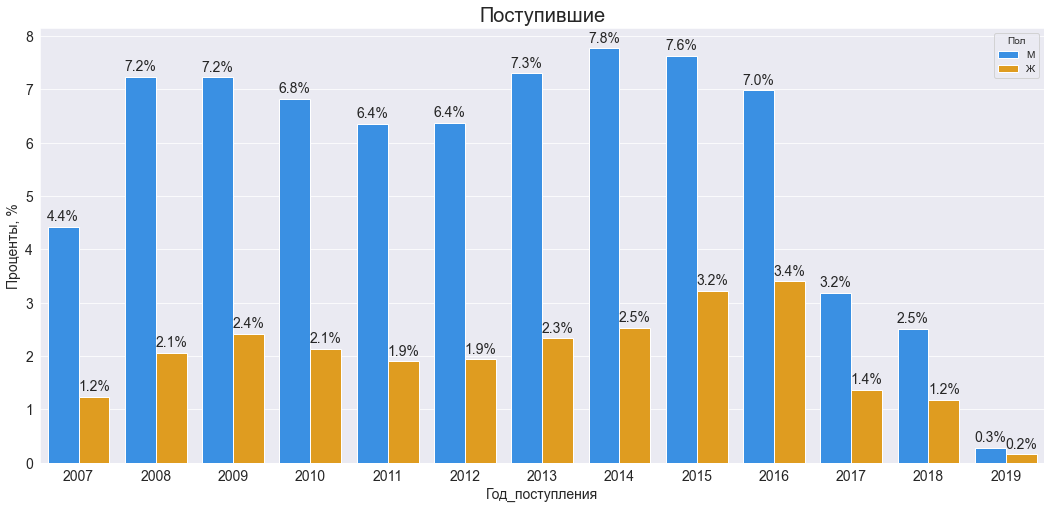

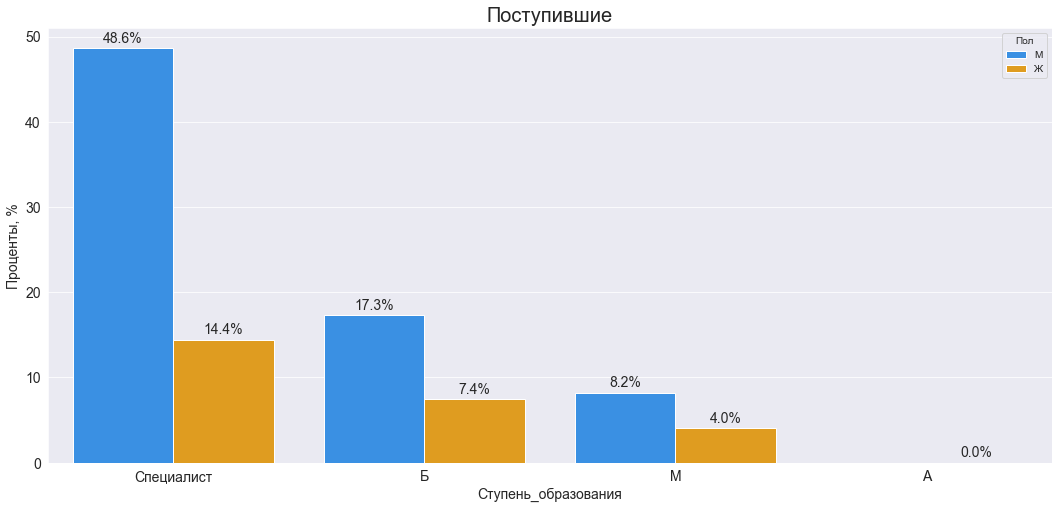

In [80]:
categorial = ['Год_поступления', 'Ступень_образования']
for i in categorial:
    bar_categorial(i, 'Пол', 'Поступившие', colors[0:2])

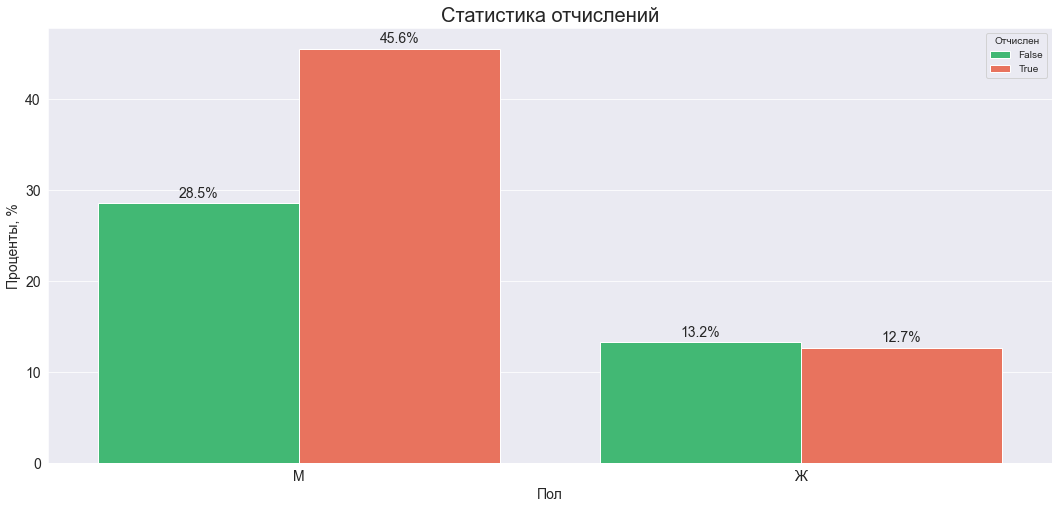

In [151]:
categorial = ['Пол']
for i in categorial:
    bar_categorial(eda_df[[i,'Отчислен']], 'Отчислен', 'Статистика отчислений', colors[2:4])

**Выводы**:
1. На каждом факультете каждый год в среднем студентки получают более высокие оценки, чем студенты. Данное явление является удивительным и сложно поддаётся анализу, причины могут быть разные.
2. В МГТУ им. Н. Э. Баумана обучается гораздо больше представителей мужского пола, чем женского.
3. Среди девушек класс закончивших немного превалирует над классом отчисленных, в то время как парней-выпуснкиков примерно в полтора раза меньше, чем невыпустившихся. Гипотеза не подтвердилась.

### Ступень образования

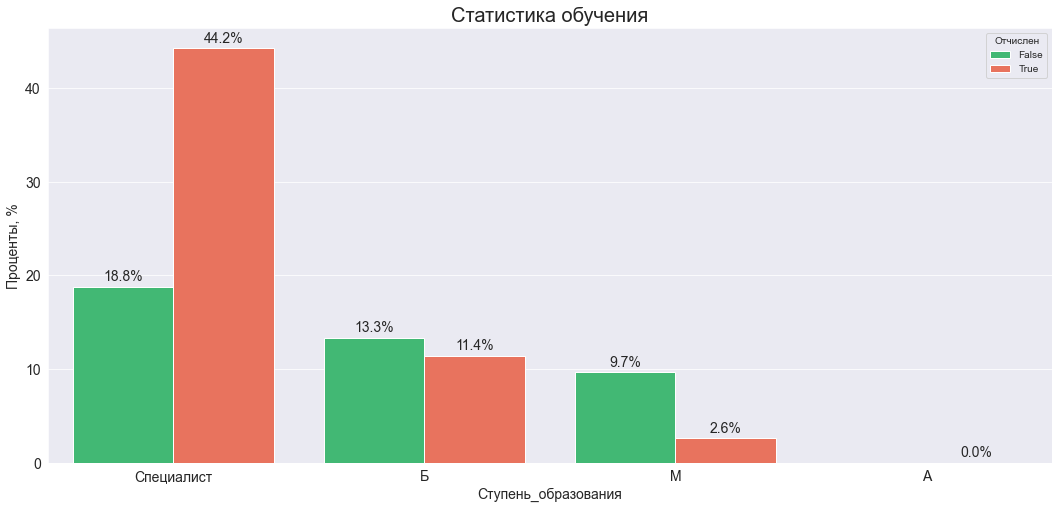

In [131]:
categorial = ['Ступень_образования']
for i in categorial:
    bar_categorial(eda_df[[i,'Отчислен']], 'Отчислен', 'Статистика обучения', colors[2:4])

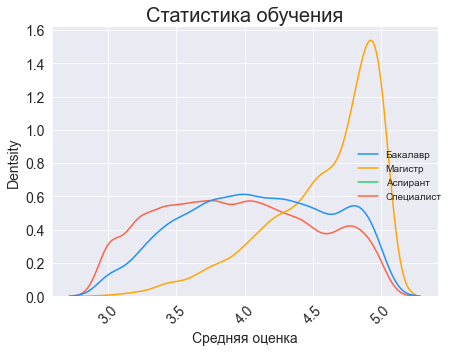

In [92]:
sns.displot({'Бакалавр': eda_df[eda_df['Ступень_образования'] == 'Б']['Средняя оценка'], \
             'Магистр': eda_df[eda_df['Ступень_образования'] == 'М']['Средняя оценка'], \
             'Аспирант': eda_df[eda_df['Ступень_образования'] == 'А']['Средняя оценка'], \
             'Специалист': eda_df[eda_df['Ступень_образования'] == 'Специалист']['Средняя оценка']}, \
            kind="kde", \
            common_norm=False,
            palette=colors)

plt.title('Статистика обучения', fontsize=20)
plt.xlabel('Средняя оценка', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

**Выводы:**
1. Графики показывают, что закончить специалитет весьма сложно ввиду большого объёма и сложности программы обучения (6 лет). Не все способны учиться по устоявшейся сложной системе образования, тем более дойти до конца.
2. С введением программы бакалавриата стало проще учиться. Нужно было завершить всего 4 года обучения, некоторые фундаментальные дисциплины урезали по объёму в программе. Примерно одинаковое количество бакалавров заканчивают и не заканчивают униерситет, однако с незначительным перевесом в пользу первых.
3. В магистратуре достаточно редко отчисляют, примерно в 4 раза. Связано это с тем, что туда идут в основном осознано, в отличие от специалитета и бакалавриата. Так же причина заключается в малом периоде обучения (всего 2 года) и меньшем количестве требований к студентам.

## Признаки и целевая функция

### Категориальные признаки

In [64]:
def compare_barplot(condition, hue):
    result = mod_df.loc[condition][[hue, 'will_dropout']]. \
                                                 groupby([hue]). \
                                                 mean(). \
                                                 reset_index(). \
                                                 sort_values(by='will_dropout', ascending=False)
    sns.barplot(x=hue, y='will_dropout', data=mod_df, order=result[hue])
    plt.show()

**Факультет**

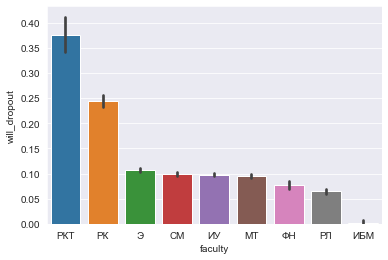

In [67]:
compare_barplot((), 'faculty')

**Ступени обучения**

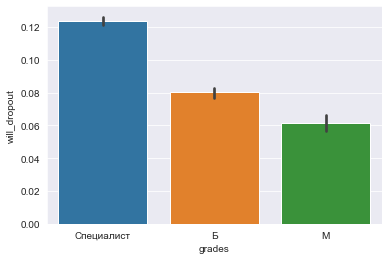

In [70]:
compare_barplot((mod_df.grades != 'А'), 'grades')

**Пол**

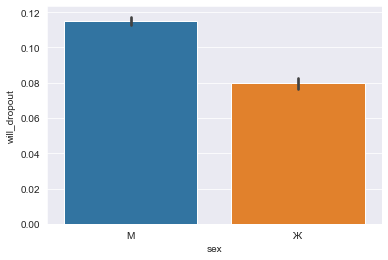

In [49]:
compare_barplot('sex')

**Выводы:**

1. Факультет влияет на целевую переменную. 
2. Влияние ступени обучения и пола на факт отчисления оценить сложно, поскольку данные содержат больше записей специалистов, нежели бакалавров и магистров. Так как университет поступает каждый год больше парней, чем девушек, сложно оценить влияние пола на отчисление. Важности всех признаков (в том числе и категориальных) будут рассмотрены в дальнейшем.

### Количественные признаки

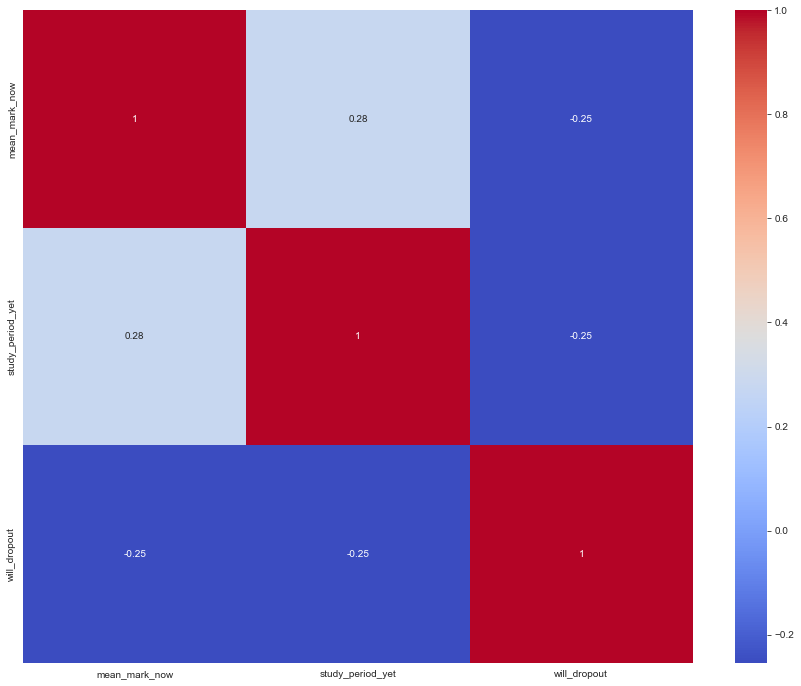

In [117]:
mod_corr = pd.get_dummies(mod_df.drop(['faculty', 'grades', 'sex', 'mean_mark_yet', 'mean_mark_first'], axis=1), drop_first=True). \
              replace({True: 1, False: 0})
correlation_matrix = mod_corr.corr()
plt.figure(figsize= (15, 12))
sns.heatmap(correlation_matrix, cmap= 'coolwarm', annot = True)

plt.show()

**Вывод:**

Средняя оценка и период обучения отрицательно коррелируют с вероятностью отчисления.

##  Моделирование

In [3]:
mod_df = pd.get_dummies(mod_df.replace({True: 1, False: 0, 'М': 1, 'Ж': 0}), drop_first=True)

In [4]:
mod_df

,mean_mark_now,mean_mark_yet,mean_mark_first,study_period_yet,will_dropout,sex,faculty_ИУ,faculty_МТ,faculty_РК,faculty_РКТ,faculty_РЛ,faculty_СМ,faculty_ФН,faculty_Э,grades_А,grades_Б,grades_Специалист
0,3.00,3.00,3.00,1.0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,3.40,3.40,3.40,1.0,1,1,0,0,0,1,0,0,0,0,0,0,1
2,4.83,4.26,4.40,9.0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,4.40,4.40,4.40,1.0,1,1,0,0,0,1,0,0,0,0,0,0,1
4,3.20,3.20,3.20,1.0,0,1,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98306,4.50,4.50,4.50,1.0,0,1,0,0,0,0,0,0,1,0,0,0,0
98307,4.33,4.40,4.50,2.0,0,1,0,0,0,0,0,0,1,0,0,0,0
98308,4.80,4.60,4.50,3.0,0,1,0,0,0,0,0,0,1,0,0,0,0
98309,4.00,4.46,4.50,4.0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [5]:
X = mod_df.drop(['will_dropout','mean_mark_yet','mean_mark_first'], axis=1)
y = mod_df.will_dropout

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Логистическая регрессия

In [7]:
lr = LogisticRegression()

In [8]:
lr.fit(X_train, y_train)

LogisticRegression()

In [9]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred_lr = lr.predict(X_test)

In [10]:
df_report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])

df_report['ROC-AUC'] = roc_auc_score(y_test, y_pred_proba)
df_report['F1'] = f1_score(y_test, y_pred_lr)
df_report['precision_0'] = precision_score(y_test, y_pred_lr, pos_label=0)
df_report['recall_0'] = recall_score(y_test, y_pred_lr, pos_label=0)
df_report['precision_1'] = precision_score(y_test, y_pred_lr, pos_label=1)
df_report['recall_1'] = recall_score(y_test, y_pred_lr, pos_label=1)

df_report.index = ['LogisticRegression']

In [11]:
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.826858,0.096056,0.899819,0.994767,0.540785,0.052709


In [12]:
def auc_graphs(model):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    plot_precision_recall_curve(model, X_test, y_test, ax=ax1)
    plot_roc_curve(model, X_test, y_test, ax=ax2)
    plt.show();

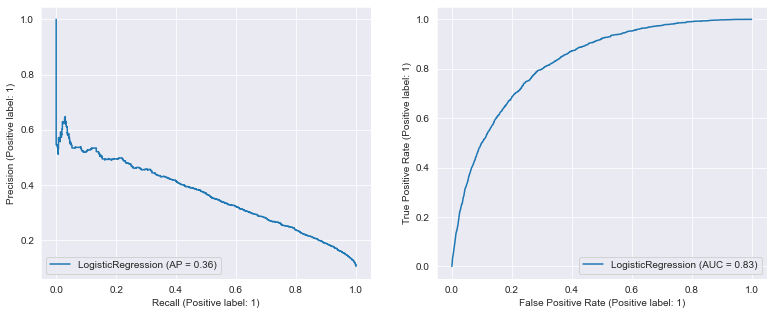

In [13]:
auc_graphs(lr)

**Вывод:**

F1 равен 0.096, что говорит о том, что алгоритм пока не способен как либо различать классы. Больше всего он присваивает объектам класс 0. Попробуем подобрать наилучшие параметры, а также сделаем стратификацию, которая часто применяется при дисбалансе классов.

In [14]:
lr_skf = LogisticRegression(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

clf_lr = GridSearchCV(lr_skf, param, scoring='roc_auc', refit=True, cv=skf)
clf_lr.fit(X_train, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_lr.best_score_, clf_lr.best_params_))

Best roc_auc: 0.8235, with best C: {'C': 8.889, 'penalty': 'l2'}


In [15]:
#Функция возвращает таблицу с метриками

def get_scores(report_df, model, X_test, y_test, name):
    
    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_0'] = precision_score(y_test, model.predict(X_test), pos_label=0)
    report['precision_1'] = precision_score(y_test, model.predict(X_test), pos_label=1)
    report['recall_0'] = recall_score(y_test, model.predict(X_test), pos_label=0)
    report['recall_1'] = recall_score(y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [16]:
df_report = get_scores(df_report, clf_lr, X_test, y_test, 'LogisticRegression_skf')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.826858,0.096056,0.899819,0.994767,0.540785,0.052709
LogisticRegression_skf,0.828123,0.373081,0.967307,0.712018,0.243808,0.794170


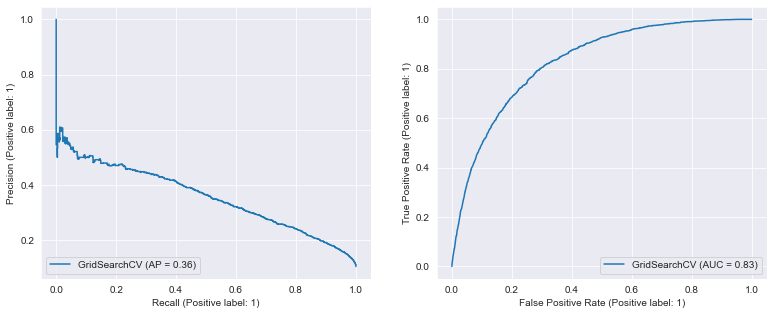

In [17]:
auc_graphs(clf_lr)

**Вывод:**

Заметно подросла полнота и в связи с этим F1. Попробуем добавить объектов недостающего класса.

In [18]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [19]:
lr_skf = LogisticRegression()
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

clf_lr_over = GridSearchCV(lr_skf, param, scoring='roc_auc', cv=skf, verbose=1)
clf_lr_over.fit(X_over, y_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_lr_over.best_score_, clf_lr_over.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best roc_auc: 0.8259, with best C: {'C': 6.667000000000001, 'penalty': 'l2'}


In [20]:
df_report = get_scores(df_report, clf_lr_over, X_test, y_test, 'LogisticRegression_skf_bal')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.826858,0.096056,0.899819,0.994767,0.540785,0.052709
LogisticRegression_skf,0.828123,0.373081,0.967307,0.712018,0.243808,0.794170
LogisticRegression_skf_bal,0.828167,0.373518,0.967218,0.713051,0.244265,0.793286


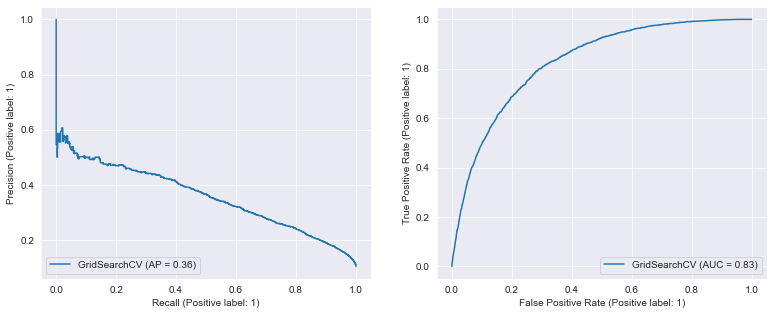

In [21]:
auc_graphs(clf_lr_over)

**Вывод:**

Очень хорошо работает встроенный параметр class_weight='balanced', но для наших данных лучше тестировать оба способа, чтобы посмотреть какой работает лучше. Модель логистической регрессии хорошо применима в случае линнейной зависимости между целевой переменной и признаками, в более сложных случах хорошо подходят композиции из решающих деревьев, так как сами решающие деревья легко переобучаются.

### Случайный лес

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
df_report = get_scores(df_report, rf, X_test, y_test, 'RandomForestClassifier')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.826858,0.096056,0.899819,0.994767,0.540785,0.052709
LogisticRegression_skf,0.828123,0.373081,0.967307,0.712018,0.243808,0.794170
LogisticRegression_skf_bal,0.828167,0.373518,0.967218,0.713051,0.244265,0.793286
RandomForestClassifier,0.837856,0.293155,0.912961,0.980411,0.544800,0.200530


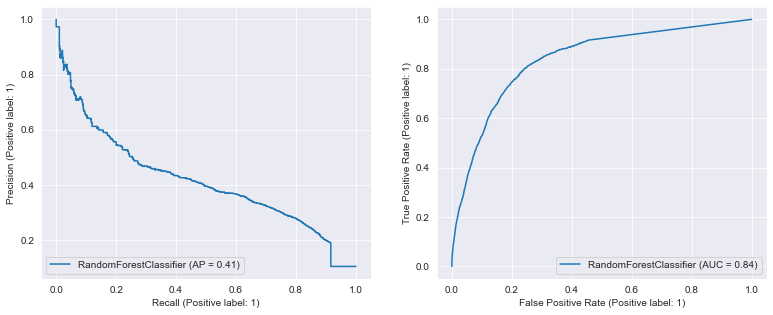

In [24]:
auc_graphs(rf)

**Вывод:**

Видим явное увеличение метрик базового алгоритма случайного леса по сравнению с базовой логистической регрессией.

In [26]:
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap': [True],
         'max_depth': [10, 20, 30],
         'n_estimators': [100, 500, 1000]}

clf_rf = GridSearchCV(rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose=3, n_jobs=-1)
clf_rf.fit(X_train, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf.best_score_, clf_rf.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best roc_auc: 0.855, with best C: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 1000}


In [27]:
df_report = get_scores(df_report, clf_rf, X_test, y_test, 'RandomForestClassifier_skf')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.826858,0.096056,0.899819,0.994767,0.540785,0.052709
LogisticRegression_skf,0.828123,0.373081,0.967307,0.712018,0.243808,0.794170
LogisticRegression_skf_bal,0.828167,0.373518,0.967218,0.713051,0.244265,0.793286
RandomForestClassifier,0.837856,0.293155,0.912961,0.980411,0.544800,0.200530
RandomForestClassifier_skf,0.857674,0.425806,0.965388,0.789307,0.296066,0.757951


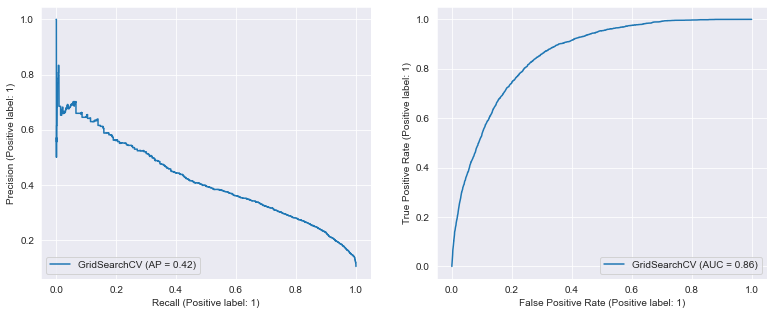

In [28]:
auc_graphs(clf_rf)

**Вывод:**

При поиске оптимальных параметров мы улучшили практически все метрики, кроме точности для первого класса (однако увеличилась полнота).

In [29]:
rf_skf = RandomForestClassifier()
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap': [True],
         'max_depth': [10, 20, 30],
         'n_estimators': [100, 500]}

clf_rf_over = GridSearchCV(rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose=3, n_jobs=-1)
clf_rf_over.fit(X_over, y_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf_over.best_score_, clf_rf_over.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best roc_auc: 0.9039, with best C: {'bootstrap': True, 'max_depth': 20, 'n_estimators': 500}


In [30]:
df_report = get_scores(df_report, clf_rf_over, X_test, y_test, 'RandomForestClassifier_skf_bal')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.826858,0.096056,0.899819,0.994767,0.540785,0.052709
LogisticRegression_skf,0.828123,0.373081,0.967307,0.712018,0.243808,0.794170
LogisticRegression_skf_bal,0.828167,0.373518,0.967218,0.713051,0.244265,0.793286
RandomForestClassifier,0.837856,0.293155,0.912961,0.980411,0.544800,0.200530
RandomForestClassifier_skf,0.857674,0.425806,0.965388,0.789307,0.296066,0.757951
RandomForestClassifier_skf_bal,0.840183,0.408921,0.968390,0.758323,0.276065,0.788280


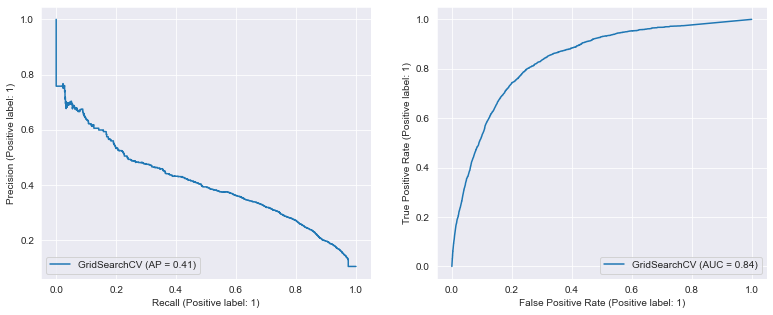

In [32]:
auc_graphs(clf_rf_over)

**Вывод:**

На сэмплированных данных полнота на первом классе стала чуть выше за счёт полноты нулевого класса. Выбираем модель RandomForestClassifier_skf исходя из метрики F1.

## Важность признаков

In [36]:
perm = PermutationImportance(clf_rf, scoring='f1').fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.1793 ± 0.0080,study_period_yet
0.0683 ± 0.0034,mean_mark_now
0.0348 ± 0.0029,grades_Специалист
0.0157 ± 0.0017,faculty_РК
0.0085 ± 0.0019,grades_Б
0.0018 ± 0.0024,faculty_СМ
0.0013 ± 0.0009,faculty_ФН
0.0007 ± 0.0011,faculty_РЛ
0.0004 ± 0.0003,faculty_РКТ
0 ± 0.0000,grades_А


**Выводы:**

1. Выдвигаемая гипотеза о преобладающей важности периода обучения подтвердилась. Чем дольше человек учится, тем меньше вероятность, что его отчислят.
2. Безусловно также большое влияние оказывает средняя оценка. Если студент учится на специалитете, то и вероятность отчисления выше. Обучение на факультете РК оказывается нежелательным из-за низкой вероятности закончить университет. Пол не влияет на возможность отчисления.